# IMPORTS AND DATASET CLASSES

In [202]:
import os
import glob
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models
from tensorflow import keras
from keras_unet_collection.utils import dummy_loader
import cv2
import gc

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize

import os
from PIL import Image

import sys
sys.path.append('cloth3d')
sys.path.append('cloth3d/DataReader')
sys.path.append('cloth3d/DataReader/smpl')

from cloth3d.DataReader.read import DataReader
from cloth3d.DataReader.depth_render import Render
from cloth3d.DataReader.util import intrinsic, extrinsic

# Path to data
SRC = 'cloth3d++_subset/'
print('SRC:', SRC)

N_TRAIN = 128
N_VAL = 16

class DataGenerator_Depth(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_list, root, model, batch_size=16, shuffle=True, data_augmentation=False):
        super().__init__()
        'Initialization'
        self.data_list = data_list
        self.root = root
        self.model = model
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        # data augmentation configuration
        self.augmenter = None
        if data_augmentation:
            self.augmenter = ImageDataGenerator(
                rotation_range=20,
                shear_range=0.2,
                horizontal_flip=True,
                fill_mode='reflect'
            )

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        data_list_temp = self.getdatalist(index)

        # Generate data
        X, y = self.__data_generation(data_list_temp)
        
        return X, y

    def getdatalist(self, index):
        'Get the list of data for one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_list_batch = [self.data_list[k] for k in indexes]

        return data_list_batch

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, data_list):
      'Generates data containing batch_size samples'
      X_img, Y_depth = [], []
      for f in data_list:
        # Load depth image
        dpt = np.load(open(self.root + f[:5] + '/depth/'+f+'.npy', 'rb'))
        mask = dpt>0
        # Normalize depth image
        min = dpt[mask].min()
        mean = dpt[mask].mean()
        max = dpt[mask].max()
        #dpt[mask] = (dpt[mask] - min + 0.001) / 2.0
        dpt[dpt>0] -= dpt[dpt>0].mean()
        dpt[dpt<0] = 0
        Y_depth.append(dpt)

        # Read RGB image
        img = cv2.imread(self.root + f[:5] + '/image/'+f+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        img = np.array(img)
        im_tensor = tf.convert_to_tensor(img, dtype=np.float32)
        im_tensor=tf.expand_dims(im_tensor, axis=0)
        pred_normals = self.model.predict(im_tensor, verbose=0)
        nml = np.array(pred_normals[0])
        
        # Normalize RGB image
        r_mean, g_mean, b_mean = [img[:, :, 0][mask].mean(), img[:, :, 1][mask].mean(), img[:, :, 2][mask].mean()]
        r_std, g_std, b_std = [img[:, :, 0][mask].std(), img[:, :, 1][mask].std(), img[:, :, 2][mask].std()]
        img[:, :, 0][mask] = (img[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        img[:, :, 1][mask] = (img[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        img[:, :, 2][mask] = (img[:, :, 2][mask] - b_mean) / (b_std + 0.0001)

        r_mean, g_mean, b_mean = [nml[:, :, 0][mask].mean(), nml[:, :, 1][mask].mean(), nml[:, :, 2][mask].mean()]
        r_std, g_std, b_std = [nml[:, :, 0][mask].std(), nml[:, :, 1][mask].std(), nml[:, :, 2][mask].std()]
        nml[:, :, 0][mask] = (nml[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        nml[:, :, 1][mask] = (nml[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        nml[:, :, 2][mask] = (nml[:, :, 2][mask] - b_mean) / (b_std + 0.0001)
        
        X_img.append(np.concatenate((img,nml),axis=-1))

      # img = preprocess(img)

      # Augment the data
      if self.augmenter is not None:
          augmented_images = []
          augmented_depth = []
          for img, depth in zip(X_img, Y_depth):

              # Modified version
              augmented = self.augmenter.random_transform(np.concatenate((img, depth[..., np.newaxis]), axis=-1))
              augmented_images.append(augmented[:, :, :6])  # RGB channels
              augmented_depth.append(augmented[:, :, 6])  # Depth channel

          X_img = augmented_images
          Y_depth = augmented_depth
          return np.array(X_img), np.array(Y_depth)

      else:
          return np.array(X_img), np.array(Y_depth)


class DataGenerator_Normals(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_list, root, batch_size=16, shuffle=True, data_augmentation=False):
        super().__init__()
        'Initialization'
        self.data_list = data_list
        self.root = root
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        # data augmentation configuration
        self.augmenter = None
        if data_augmentation:
            self.augmenter = ImageDataGenerator(
                rotation_range=20,
                shear_range=0.2,
                horizontal_flip=True,
                fill_mode='reflect'
            )

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        data_list_temp = self.getdatalist(index)

        # Generate data
        X, y = self.__data_generation(data_list_temp)
        
        return X, y

    def getdatalist(self, index):
        'Get the list of data for one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_list_batch = [self.data_list[k] for k in indexes]

        return data_list_batch

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, data_list):
      'Generates data containing batch_size samples'
      X_img, Y_normal = [], []
      for f in data_list:
        # Load depth image
        dpt = np.load(open(self.root + f[:5] + '/depth/'+f+'.npy', 'rb'))
        mask = dpt>0
        # Normalize depth image
        #min = dpt[mask].min()
        #mean = dpt[mask].mean()
        #max = dpt[mask].max()
        #dpt[mask] = (dpt[mask] - min + 0.001) / 2.0
        dpt[dpt>0] -= dpt[dpt>0].mean()
        dpt[dpt<0] = 0

        # Read RGB image
        img = cv2.imread(self.root + f[:5] + '/image/'+f+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        img = np.array(img)

        nml = cv2.imread(self.root + f[:5] + '/normals/'+f+'.jpg')
        nml = np.array(nml)
        
        # Normalize RGB image
        r_mean, g_mean, b_mean = [img[:, :, 0][mask].mean(), img[:, :, 1][mask].mean(), img[:, :, 2][mask].mean()]
        r_std, g_std, b_std = [img[:, :, 0][mask].std(), img[:, :, 1][mask].std(), img[:, :, 2][mask].std()]
        img[:, :, 0][mask] = (img[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        img[:, :, 1][mask] = (img[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        img[:, :, 2][mask] = (img[:, :, 2][mask] - b_mean) / (b_std + 0.0001)

        r_mean, g_mean, b_mean = [nml[:, :, 0][mask].mean(), nml[:, :, 1][mask].mean(), nml[:, :, 2][mask].mean()]
        r_std, g_std, b_std = [nml[:, :, 0][mask].std(), nml[:, :, 1][mask].std(), nml[:, :, 2][mask].std()]
        nml[:, :, 0][mask] = (nml[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        nml[:, :, 1][mask] = (nml[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        nml[:, :, 2][mask] = (nml[:, :, 2][mask] - b_mean) / (b_std + 0.0001)
        
        X_img.append(img)
        Y_normal.append(nml)

      # img = preprocess(img)

      # Augment the data
      if self.augmenter is not None:
          augmented_images = []
          augmented_normals = []
          for img, normal in zip(X_img, Y_normal):

              # Modified version
              augmented = self.augmenter.random_transform(np.concatenate((img, normal), axis=-1))
              augmented_images.append(augmented[:, :, :3])  # RGB channels
              augmented_normals.append(augmented[:, :, 3:])  # Normal channels

          X_img = augmented_images
          Y_normal = augmented_normals
          return np.array(X_img), np.array(Y_normal)

      else:
          return np.array(X_img), np.array(Y_normal)
      
class DataGenerator_Together(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_list, root, batch_size=16, shuffle=True, data_augmentation=False):
        super().__init__()
        'Initialization'
        self.data_list = data_list
        self.root = root
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        # data augmentation configuration
        self.augmenter = None
        if data_augmentation:
            self.augmenter = ImageDataGenerator(
                rotation_range=20,
                shear_range=0.2,
                horizontal_flip=True,
                fill_mode='reflect'
            )

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        data_list_temp = self.getdatalist(index)

        # Generate data
        X, y = self.__data_generation(data_list_temp)
        
        return X, y

    def getdatalist(self, index):
        'Get the list of data for one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_list_batch = [self.data_list[k] for k in indexes]

        return data_list_batch

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, data_list):
      'Generates data containing batch_size samples'
      X_img, Y = [], []
      for f in data_list:
        # Load depth image
        dpt = np.load(open(self.root + f[:5] + '/depth/'+f+'.npy', 'rb'))
        mask = dpt>0
        # Normalize depth image
        #min = dpt[mask].min()
        #mean = dpt[mask].mean()
        #max = dpt[mask].max()
        #dpt[mask] = (dpt[mask] - min + 0.001) / 2.0
        dpt[dpt>0] -= dpt[dpt>0].mean()
        dpt[dpt<0] = 0

        # Read RGB image
        img = cv2.imread(self.root + f[:5] + '/image/'+f+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        img = np.array(img)

        nml = cv2.imread(self.root + f[:5] + '/normals/'+f+'.jpg')
        nml = np.array(nml)
        
        # Normalize RGB image
        r_mean, g_mean, b_mean = [img[:, :, 0][mask].mean(), img[:, :, 1][mask].mean(), img[:, :, 2][mask].mean()]
        r_std, g_std, b_std = [img[:, :, 0][mask].std(), img[:, :, 1][mask].std(), img[:, :, 2][mask].std()]
        img[:, :, 0][mask] = (img[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        img[:, :, 1][mask] = (img[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        img[:, :, 2][mask] = (img[:, :, 2][mask] - b_mean) / (b_std + 0.0001)

        r_mean, g_mean, b_mean = [nml[:, :, 0][mask].mean(), nml[:, :, 1][mask].mean(), nml[:, :, 2][mask].mean()]
        r_std, g_std, b_std = [nml[:, :, 0][mask].std(), nml[:, :, 1][mask].std(), nml[:, :, 2][mask].std()]
        nml[:, :, 0][mask] = (nml[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        nml[:, :, 1][mask] = (nml[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        nml[:, :, 2][mask] = (nml[:, :, 2][mask] - b_mean) / (b_std + 0.0001)
        
        X_img.append(img)
        Y.append(np.concatenate((dpt[..., np.newaxis], nml), axis=-1))

      # img = preprocess(img)

      # Augment the data
      if self.augmenter is not None:
          augmented_images = []
          augmented_y = []
          for img, target in zip(X_img, Y):

              # Modified version
              augmented = self.augmenter.random_transform(np.concatenate((img, target), axis=-1))
              augmented_images.append(augmented[:, :, :3])  # RGB channels
              augmented_y.append(augmented[:, :, 3:])  # Normal channels

          X_img = augmented_images
          Y = augmented_y
          return np.array(X_img), np.array(Y)

      else:
          return np.array(X_img), np.array(Y)



SRC: cloth3d/Samples/


# MODELS

In [203]:
# Create model
model_together = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=4,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Sigmoid', 
                      batch_norm=True, pool='max', unpool=False, name='unet')
model_normals= models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=3,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Sigmoid', 
                      batch_norm=True, pool='max', unpool=False, name='unet')
model_depth = models.unet_2d((256, 256, 6), [64, 128, 256, 512, 1024], n_labels=1,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Sigmoid', 
                      batch_norm=True, pool='max', unpool=False, name='unet')

# DATA LISTS

In [204]:
# Read the data lists
SRC = 'cloth3d/Samples/'
subfolders = [x for x in os.listdir(SRC) if x.isdigit()]
subfolders.sort(key=int)
print(subfolders)

training_folders = subfolders
validation_folders = subfolders
test_folders = subfolders

train_list = []
for sample in training_folders:
    try:
        train_list += os.listdir(SRC + sample + '/image')
    except:
        pass
train_list = list(map(lambda filename: filename[:-4], train_list))[0::80]

validation_list = []
for sample in validation_folders:
    try:
        validation_list += os.listdir(SRC + sample + '/image')
    except:
        pass
validation_list = list(map(lambda filename: filename[:-4], validation_list))[0::80]

test_list = []
for sample in test_folders:
    try:
        test_list += os.listdir(SRC + sample + '/image')
    except:
        pass
test_list = list(map(lambda filename: filename[:-4], test_list))[0::80]

['03543']


In [10]:
# Read the data lists
SRC = 'cloth3d++_subset/'
subfolders = [x for x in os.listdir(SRC) if x.isdigit()]
subfolders.sort(key=int)
print(subfolders)

training_folders = subfolders[:N_TRAIN]
validation_folders = subfolders[N_TRAIN:N_TRAIN+N_VAL]
test_folders = subfolders[N_TRAIN+N_VAL:]

train_list = []
for sample in training_folders:
    try:
        train_list += os.listdir(SRC + sample + '/image')
    except:
        pass
train_list = list(map(lambda filename: filename[:-4], train_list))[0::80]
to_remove = [261, 259, 188]

for x in to_remove:
    del train_list[x]

validation_list = []
for sample in validation_folders:
    try:
        validation_list += os.listdir(SRC + sample + '/image')
    except:
        pass
validation_list = list(map(lambda filename: filename[:-4], validation_list))[0::30]

test_list = []
for sample in test_folders:
    try:
        test_list += os.listdir(SRC + sample + '/image')
    except:
        pass
test_list = list(map(lambda filename: filename[:-4], test_list))[0::30]

['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00011', '00012', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00023', '00024', '00027', '00028', '00029', '00030', '00031', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00043', '00044', '00045', '00046', '00048', '00049', '00050', '00051', '00053', '00054', '00056', '00057', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00065', '00066', '00067', '00068', '00069', '00070', '00071', '00072', '00073', '00074', '00076', '00077', '00081', '00082', '00083', '00084', '00085', '00086', '00087', '00088', '00089', '00090', '00091', '00092', '00093', '00096', '00097', '00098', '00100', '00101', '00102', '00103', '00105', '00106', '00107', '00108', '00110', '00112', '00113', '00114', '00115', '00116', '00117', '00118', '00120', '00121', '00122', '00124', '00125', '00127', '00128', '00129', '00130', '00131', '00132', '00133', '00134', 

In [206]:
print(len(train_list))
print(len(validation_list))
print(len(test_list))

4
4
4


# TRAIN ALL-TOGETHER MODEL

In [207]:
# hyperparameters
lr = 1e-3
batch_size = 4
n_epochs = 2
checkpoint = './best_model_AT.keras'
shuffle = True
verbose = 1

# Training

# creating data generators to load the data
train_together = DataGenerator_Together(train_list, SRC, batch_size=batch_size, shuffle=shuffle, data_augmentation=True)
validation_together = DataGenerator_Together(validation_list, SRC, batch_size=batch_size, shuffle=False)
print('Number of data used to train:')
print(len(train_together.data_list))
print('')

# defining the optimizer
model_together.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

# training the model and saving the history
history_together = model_together.fit(train_together, validation_data=validation_together, epochs=n_epochs, verbose=verbose, callbacks=[mc, es])

#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of data used to train:
4

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 913.7979 - mae: 5.7349 - val_loss: 1327.4711 - val_mae: 5.7539
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 917.3655 - mae: 5.6676 - val_loss: 1324.9541 - val_mae: 5.8042


In [208]:
# Evaluate the trained model on the test set

test_together = DataGenerator_Together(test_list, SRC, batch_size=1, shuffle=False)

# model.load_weights(checkpoint)

print('Evaluating on the test set')

_mae = 0
for step in range(test_together.__len__()):
  # Load the batch
  X, Y = test_together.__getitem__(step)
  
  # validate on one batch
  prediction = model_together.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)
  
  # Note that in the evaluation the background is ignored
  # Therefore the MAE on the test set is not comparable with the train/validation
  #_mae += np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  #_mae_depth = np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  _mae += np.abs(prediction - Y).mean()
  _mae_depth = np.abs(prediction[:,:,:,0] - Y[:,:,:,0]).mean()


  # Some house keeping
  gc.collect()
  tf.keras.backend.clear_session()

print("The total mean absolute error is {0:.3f}\n".format(_mae/(step+1)))
print("The depth mean absolute error is {0:.3f}\n".format(_mae_depth/(step+1)))

Evaluating on the test set
The total mean absolute error is 5.804

The depth mean absolute error is 0.140



In [209]:
# Load the batch
step = 0
test_together = DataGenerator_Together(test_list, SRC, batch_size=1, shuffle=False)
X, Y = test_together.__getitem__(step)

# Validate on one batch
prediction = model_together.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)

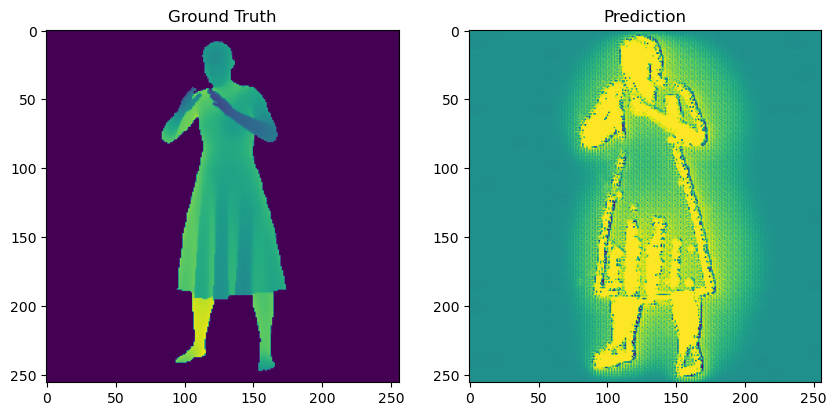

In [210]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth
axes[0].imshow(Y[0,:,:,0])
axes[0].set_title('Ground Truth')

# Plot prediction
axes[1].imshow(prediction[0,:,:,0])
axes[1].set_title('Prediction')

# Display the subplots
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


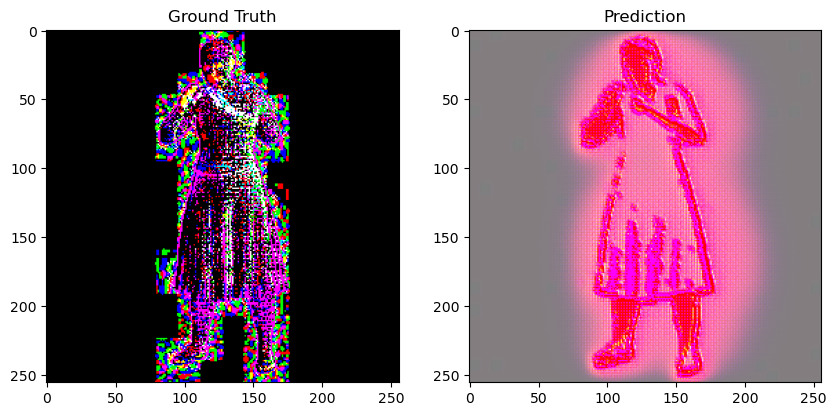

In [211]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth
axes[0].imshow(Y[0,:,:,1:])
axes[0].set_title('Ground Truth')

# Plot prediction
axes[1].imshow(prediction[0,:,:,1:])
axes[1].set_title('Prediction')

# Display the subplots
plt.show()

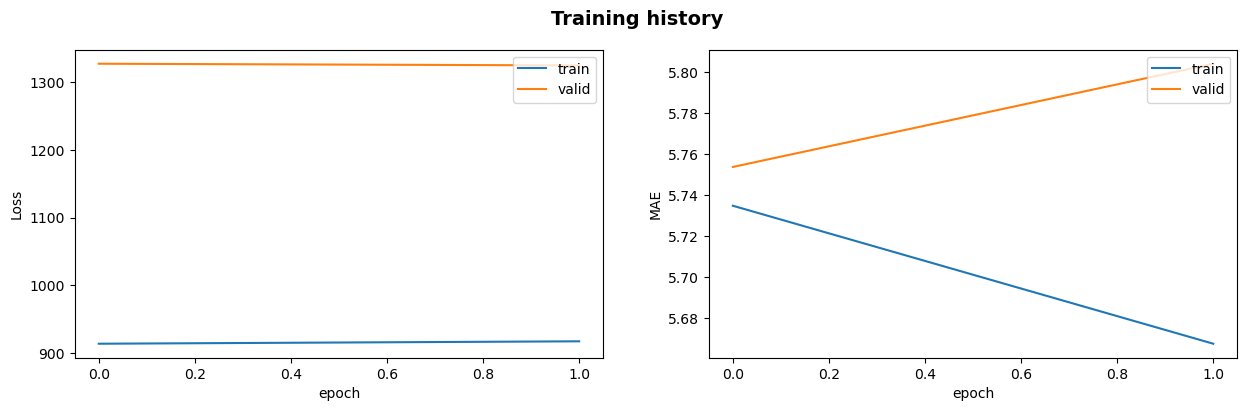

In [212]:
# Visualization
train_hist = history_together.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

# TRAIN SEQUENTIAL MODEL

In [213]:
# hyperparameters
lr = 1e-3
batch_size = 4
n_epochs = 2
checkpoint = './best_model_N.keras'
shuffle = True
verbose = 1

# Training

# creating data generators to load the data
train_normals = DataGenerator_Normals(train_list, SRC, batch_size=batch_size, shuffle=shuffle, data_augmentation=True)
validation_normals = DataGenerator_Normals(validation_list, SRC, batch_size=batch_size, shuffle=False)
print('Number of data used to train:')
print(len(train_normals.data_list))
print('')

# defining the optimizer
model_normals.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

# training the model and saving the history
history_normals = model_normals.fit(train_normals, validation_data=validation_normals, epochs=n_epochs, verbose=verbose, callbacks=[mc, es])

#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of data used to train:
4

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 1210.1362 - mae: 7.4842 - val_loss: 1764.3700 - val_mae: 7.5593
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1213.2450 - mae: 7.3973 - val_loss: 1763.4208 - val_mae: 7.6854


In [214]:
# Evaluate the trained model on the test set

test_normals = DataGenerator_Normals(test_list, SRC, batch_size=1, shuffle=False)

# model.load_weights(checkpoint)

print('Evaluating on the test set')

_mae = 0
for step in range(test_normals.__len__()):
  # Load the batch
  X, Y = test_normals.__getitem__(step)
  
  # validate on one batch
  prediction = model_normals.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)
  
  # Note that in the evaluation the background is ignored
  # Therefore the MAE on the test set is not comparable with the train/validation
  #_mae += np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  #_mae_depth = np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  _mae += np.abs(prediction - Y).mean()


  # Some house keeping
  gc.collect()
  tf.keras.backend.clear_session()

print("The normals mean absolute error is {0:.3f}\n".format(_mae/(step+1)))

Evaluating on the test set
The normals mean absolute error is 7.685



In [215]:
# Load the batch
step = 0
test_normals = DataGenerator_Normals(test_list, SRC, batch_size=1, shuffle=False)
X, Y = test_normals.__getitem__(step)

# Validate on one batch
prediction = model_normals.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)

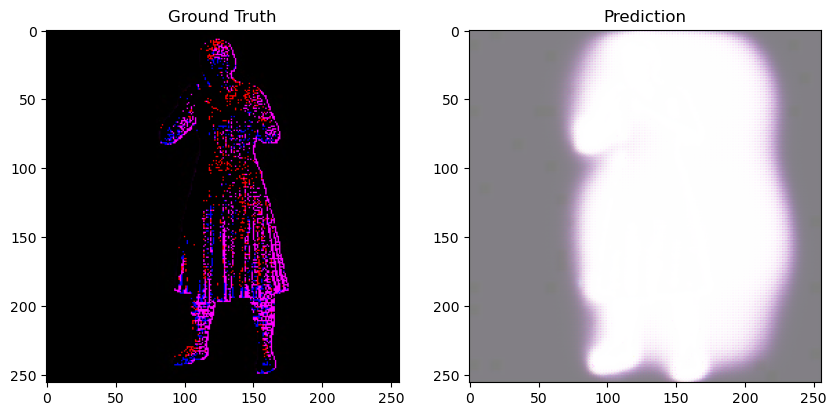

In [216]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth
axes[0].imshow(Y[0])
axes[0].set_title('Ground Truth')

# Plot prediction
axes[1].imshow(prediction[0])
axes[1].set_title('Prediction')

# Display the subplots
plt.show()

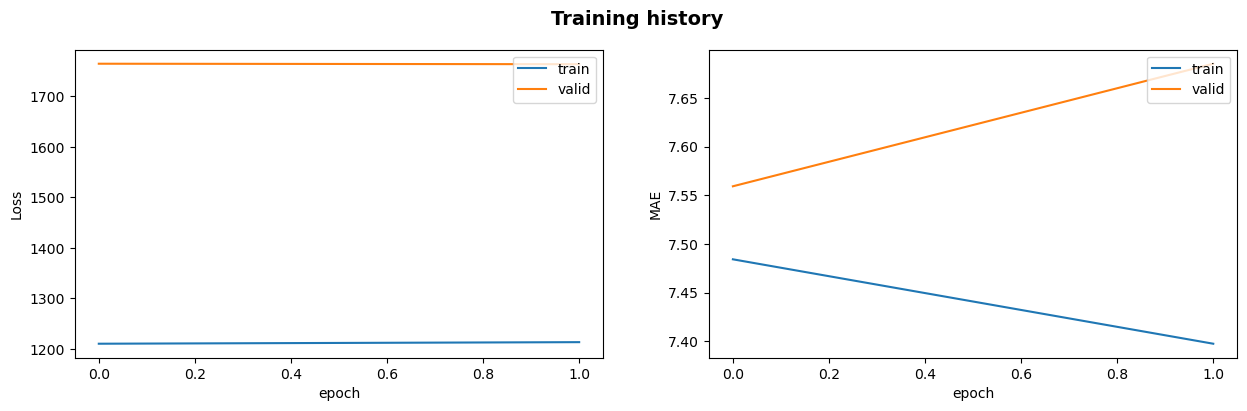

In [217]:
# Visualization
train_hist = history_normals.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

In [218]:
# hyperparameters
lr = 1e-3
batch_size = 4
n_epochs = 2
checkpoint = './best_model_S.keras'
shuffle = True
verbose = 1

# Training

# creating data generators to load the data
train_depth = DataGenerator_Depth(train_list, SRC, model_normals, batch_size=batch_size, shuffle=shuffle, data_augmentation=True)
validation_depth = DataGenerator_Depth(validation_list, SRC, model_normals, batch_size=batch_size, shuffle=False)
print('Number of data used to train:')
print(len(train_normals.data_list))
print('')

# defining the optimizer
model_depth.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

# training the model and saving the history
history_depth = model_depth.fit(train_depth, validation_data=validation_depth, epochs=n_epochs, verbose=verbose, callbacks=[mc, es])

#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of data used to train:
4

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.2188 - mae: 0.4347WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x7f96dc7c5d00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.2188 - mae: 0.4347 - val_loss: 0.3987 - val_mae: 0.6066
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1318 - mae: 0.3116 -

In [219]:
# Evaluate the trained model on the test set

test_depth = DataGenerator_Depth(test_list, SRC, model_normals, batch_size=1, shuffle=False)

# model.load_weights(checkpoint)

print('Evaluating on the test set')

_mae = 0
for step in range(test_depth.__len__()):
  # Load the batch
  X, Y = test_depth.__getitem__(step)
  
  # validate on one batch
  prediction = model_depth.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)
  
  # Note that in the evaluation the background is ignored
  # Therefore the MAE on the test set is not comparable with the train/validation
  #_mae += np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  #_mae_depth = np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  _mae += np.abs(prediction - Y).mean()


  # Some house keeping
  gc.collect()
  tf.keras.backend.clear_session()

print("The depth mean absolute error is {0:.3f}\n".format(_mae/(step+1)))

Evaluating on the test set
The depth mean absolute error is 0.781



In [220]:
# Load the batch
step = 0
test_depth = DataGenerator_Depth(test_list, SRC, model_normals, batch_size=1, shuffle=False)
X, Y = test_depth.__getitem__(step)

# Validate on one batch
prediction = model_depth.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)

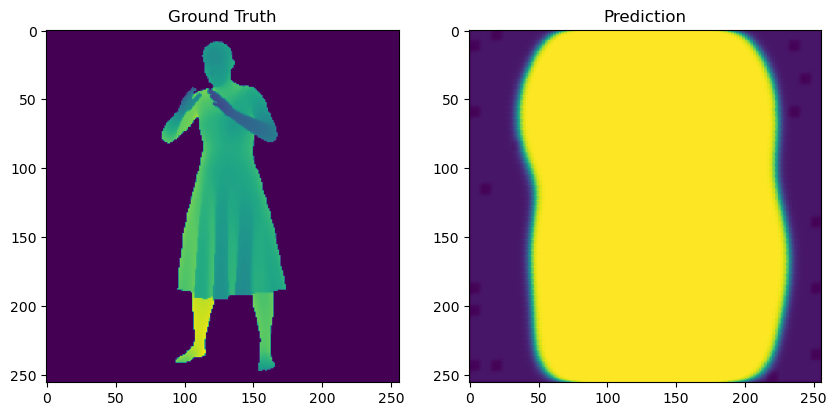

In [221]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth
axes[0].imshow(Y[0])
axes[0].set_title('Ground Truth')

# Plot prediction
axes[1].imshow(prediction[0])
axes[1].set_title('Prediction')

# Display the subplots
plt.show()

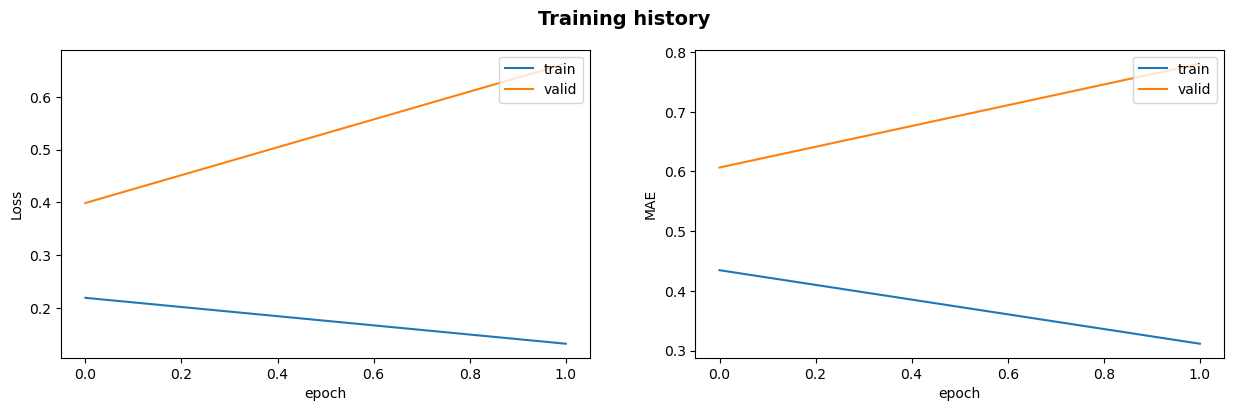

In [222]:
# Visualization
train_hist = history_depth.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')